# Imports

In [13]:
!pip install split-folders

In [14]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from tensorflow.keras import layers
import os
import seaborn as sns
from collections import Counter
from keras import backend as K
plt.style.use("ggplot")
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import glob
from pathlib import Path
import cv2
import shutil
import splitfolders
from sklearn.metrics import accuracy_score, classification_report
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from keras.applications import VGG16

# Functions

In [15]:
def plt_show(image, axis = True):
    img = plt.imread(image)
    plt.imshow(img)
    if axis == False: 
        plt.axis("off");
    print(img.shape)

In [16]:
def load_images(imdir):
    ext = ['png', 'jpg', 'gif',"JPG"]
    imgs = []
    [imgs.extend(glob.glob(imdir + '/*.' + e)) for e in ext]
    images = [cv2.imread(i) for i in imgs]
    return images

# PreProcessing

(150, 150, 3)


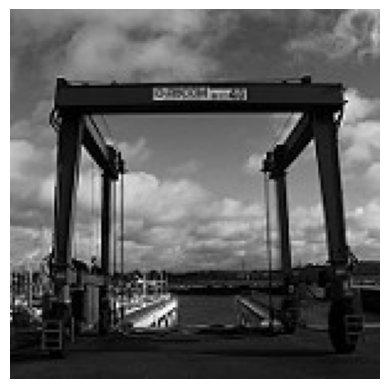

In [17]:
plt_show("/kaggle/input/intel-image-classification/seg_train/seg_train/sea/1.jpg", axis = False)

In [18]:
# Split training folder to train Folder & validation Folder
splitfolders.ratio('/kaggle/input/intel-image-classification/seg_train/seg_train', output="output", seed=1337, ratio=(0.8, 0.2)) 

Copying files: 14034 files [00:36, 379.72 files/s]


In [19]:
val_test_gen = ImageDataGenerator(rescale = 1.0 / 255)

train_generator = val_test_gen.flow_from_directory(
    "/kaggle/working/output/train",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)
validation_generator = val_test_gen.flow_from_directory(
    "/kaggle/working/output/val",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)

test_generator = val_test_gen.flow_from_directory(
        "/kaggle/input/intel-image-classification/seg_test/seg_test",
        target_size=(150, 150),
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Baseline Model

In [20]:
input_size = 150
model = tf.keras.Sequential([
    layers.Conv2D(input_shape=(input_size,input_size,3),filters = 32,kernel_size=(3,3),padding = 'same',activation='relu'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters= 64,kernel_size=(3,3),activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters = 64,kernel_size=(3,3),activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters = 128,kernel_size=(3,3),activation='relu',padding = 'same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters = 256,kernel_size=(3,3),activation='relu',padding = 'same'),
    layers.MaxPool2D(),
    
    layers.Flatten(name='flatten'),
    layers.Dense(150, activation = 'relu'),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(6, activation = 'softmax')
    
])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 37, 37, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 18, 18, 64)      

In [22]:
#plot_model(model,show_shapes=True)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [24]:
history = model.fit(train_generator, steps_per_epoch = 11224 // 32,
                    validation_steps = 2810 // 32,
                    epochs = 15,
                    validation_data = validation_generator)

Epoch 1/15
350/350 [==============================] - 24s 60ms/step - loss: 1.0572 - accuracy: 0.5726 - val_loss: 0.8212 - val_accuracy: 0.6853
Epoch 2/15
350/350 [==============================] - 18s 52ms/step - loss: 0.7252 - accuracy: 0.7256 - val_loss: 0.5847 - val_accuracy: 0.7798
Epoch 3/15
350/350 [==============================] - 18s 50ms/step - loss: 0.5757 - accuracy: 0.7927 - val_loss: 0.5951 - val_accuracy: 0.7830
Epoch 4/15
350/350 [==============================] - 20s 58ms/step - loss: 0.4732 - accuracy: 0.8339 - val_loss: 0.5299 - val_accuracy: 0.8060
Epoch 5/15
350/350 [==============================] - 20s 56ms/step - loss: 0.4099 - accuracy: 0.8517 - val_loss: 0.5826 - val_accuracy: 0.7999
Epoch 6/15
350/350 [==============================] - 20s 56ms/step - loss: 0.3560 - accuracy: 0.8702 - val_loss: 0.4876 - val_accuracy: 0.8351
Epoch 7/15
350/350 [==============================] - 18s 52ms/step - loss: 0.3103 - accuracy: 0.8904 - val_loss: 0.4448 - val_accuracy:

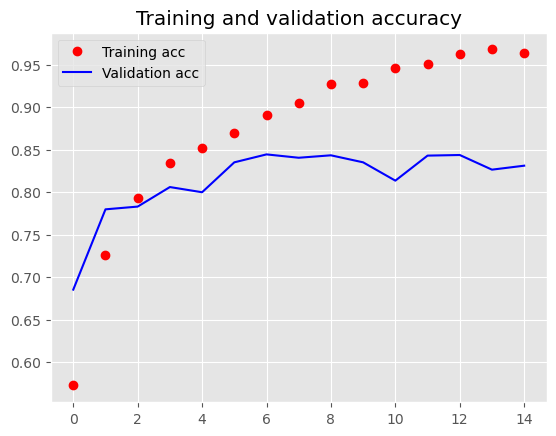

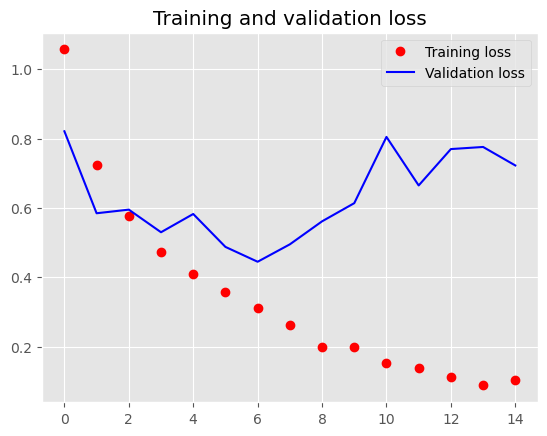

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
y_pred = model.predict(test_generator)
y_pred = [i.argmax() for i in y_pred]
sorted(Counter(y_pred).items())

3000/3000 [==============================] - 26s 8ms/step


[(0, 404), (1, 468), (2, 461), (3, 607), (4, 535), (5, 525)]

In [27]:
y_test = test_generator.classes
sorted(Counter(y_test).items())

[(0, 437), (1, 474), (2, 553), (3, 525), (4, 510), (5, 501)]

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       437
           1       0.97      0.96      0.96       474
           2       0.85      0.71      0.77       553
           3       0.71      0.83      0.77       525
           4       0.81      0.85      0.83       510
           5       0.83      0.87      0.85       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



In [29]:
epochs = np.linspace(0.0,15.0,num = 20)
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Scatter(
    x=epochs,
    y=acc,
    mode = "lines+markers",
    name = "Training accuracy"
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=epochs,
    y=val_acc,
    mode = "lines+markers", 
    name = "Validation accuracy"
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=epochs,
    y=loss,
    mode = "lines+markers",
    name = "Training loss"
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=epochs,
    y=val_loss,
    mode = "lines+markers", 
    name = "Validation loss"
), row=1, col=2)


fig.update_layout()
fig.show()

# Using Data augmentation

In [30]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    "/kaggle/working/output/train",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)

validation_generator = val_test_gen.flow_from_directory(
    "/kaggle/working/output/val",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)

Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.


In [32]:
history = model.fit(train_generator, steps_per_epoch = 11224 // 32,
                    validation_steps = 2810 // 32,
                    epochs = 15,
                    validation_data = validation_generator)

Epoch 1/15
350/350 [==============================] - 80s 229ms/step - loss: 0.5736 - accuracy: 0.7908 - val_loss: 0.5164 - val_accuracy: 0.8244
Epoch 2/15
350/350 [==============================] - 81s 232ms/step - loss: 0.5741 - accuracy: 0.7920 - val_loss: 0.4647 - val_accuracy: 0.8438
Epoch 3/15
350/350 [==============================] - 81s 231ms/step - loss: 0.5480 - accuracy: 0.8040 - val_loss: 0.5093 - val_accuracy: 0.8161
Epoch 4/15
350/350 [==============================] - 79s 226ms/step - loss: 0.5360 - accuracy: 0.8135 - val_loss: 0.5410 - val_accuracy: 0.8175
Epoch 5/15
350/350 [==============================] - 79s 225ms/step - loss: 0.5172 - accuracy: 0.8093 - val_loss: 0.4552 - val_accuracy: 0.8430
Epoch 6/15
350/350 [==============================] - 82s 234ms/step - loss: 0.5095 - accuracy: 0.8133 - val_loss: 0.5108 - val_accuracy: 0.8261
Epoch 7/15
350/350 [==============================] - 79s 226ms/step - loss: 0.4893 - accuracy: 0.8254 - val_loss: 0.4762 - val_ac

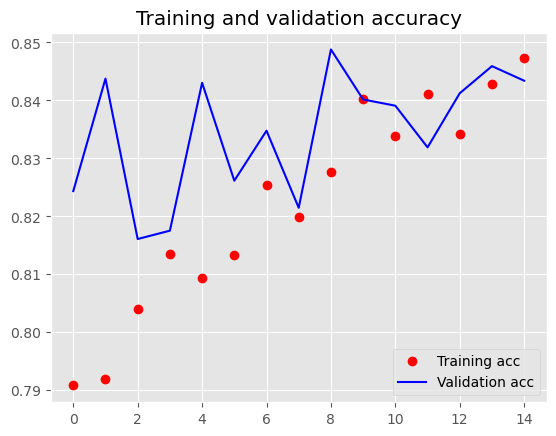

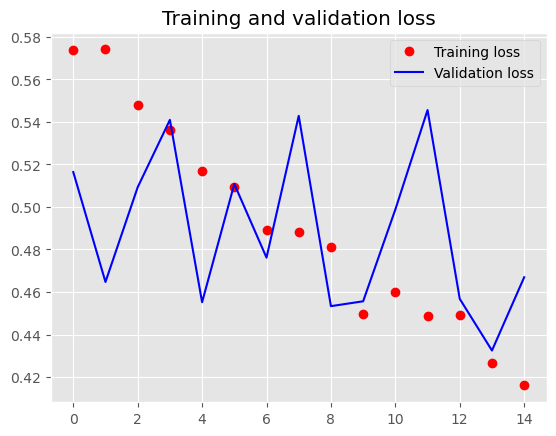

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
y_pred = model.predict(test_generator)
y_pred = [i.argmax() for i in y_pred]
sorted(Counter(y_pred).items())

3000/3000 [==============================] - 12s 4ms/step


[(0, 458), (1, 439), (2, 551), (3, 432), (4, 544), (5, 576)]

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.80      0.78       437
           1       0.97      0.90      0.94       474
           2       0.83      0.82      0.83       553
           3       0.87      0.71      0.78       525
           4       0.83      0.89      0.86       510
           5       0.82      0.94      0.88       501

    accuracy                           0.84      3000
   macro avg       0.85      0.84      0.84      3000
weighted avg       0.85      0.84      0.84      3000



# Using Transfer Learning Without Fine Tuning

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    "/kaggle/working/output/train",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)

validation_generator = val_test_gen.flow_from_directory(
    "/kaggle/working/output/val",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)

Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.


In [37]:
conv_base = VGG16(weights = "imagenet", include_top = False, input_shape = (150,150,3))
conv_base.trainable = False
input_size = 150
model = tf.keras.Sequential([
    conv_base,
    layers.Flatten(name='flatten'),
    layers.Dense(150, activation = 'relu'),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(6, activation = 'softmax')
    
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 150)               1228950   
                                                                 
 dense_7 (Dense)             (None, 100)               15100     
                                                                 
 dense_8 (Dense)             (None, 6)                 606       
                                                                 
Total params: 15,959,344
Trainable params: 1,244,656
Non-trainable params: 14,714,688
___________________________________

In [38]:
history = model.fit(train_generator, steps_per_epoch = 11224 // 32,
                    validation_steps = 2810 // 32,
                    epochs = 15,
                    validation_data = validation_generator)

Epoch 1/15
350/350 [==============================] - 103s 284ms/step - loss: 0.6454 - accuracy: 0.7522 - val_loss: 0.4586 - val_accuracy: 0.8290
Epoch 2/15
350/350 [==============================] - 92s 263ms/step - loss: 0.5136 - accuracy: 0.8087 - val_loss: 0.4256 - val_accuracy: 0.8445
Epoch 3/15
350/350 [==============================] - 92s 264ms/step - loss: 0.4762 - accuracy: 0.8205 - val_loss: 0.4844 - val_accuracy: 0.8218
Epoch 4/15
350/350 [==============================] - 91s 261ms/step - loss: 0.4593 - accuracy: 0.8255 - val_loss: 0.3880 - val_accuracy: 0.8617
Epoch 5/15
350/350 [==============================] - 91s 259ms/step - loss: 0.4389 - accuracy: 0.8344 - val_loss: 0.4067 - val_accuracy: 0.8527
Epoch 6/15
350/350 [==============================] - 92s 262ms/step - loss: 0.4198 - accuracy: 0.8398 - val_loss: 0.3722 - val_accuracy: 0.8635
Epoch 7/15
350/350 [==============================] - 96s 275ms/step - loss: 0.4277 - accuracy: 0.8380 - val_loss: 0.3708 - val_a

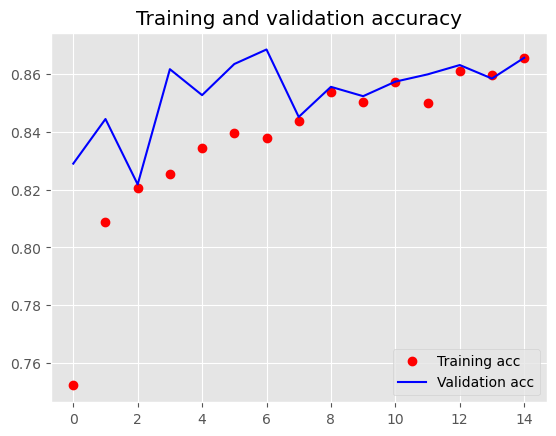

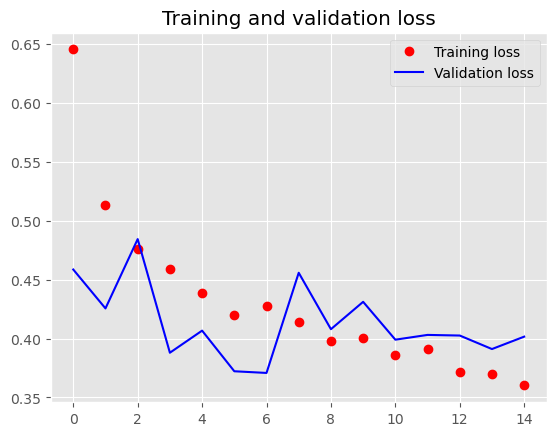

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
y_pred = model.predict(test_generator)
y_pred = [i.argmax() for i in y_pred]
sorted(Counter(y_pred).items())

3000/3000 [==============================] - 20s 6ms/step


[(0, 446), (1, 470), (2, 640), (3, 495), (4, 436), (5, 513)]

In [41]:
model.evaluate(test_generator)

3000/3000 [==============================] - 24s 8ms/step - loss: 0.3721 - accuracy: 0.8633


[0.3721240758895874, 0.8633333444595337]

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       437
           1       0.98      0.97      0.97       474
           2       0.75      0.87      0.80       553
           3       0.81      0.76      0.79       525
           4       0.91      0.78      0.84       510
           5       0.88      0.90      0.89       501

    accuracy                           0.86      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.86      0.86      3000



# TL With Fine Tuning

In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [44]:
conv_base.trainable = True
set_trainable = False
for i in conv_base.layers:
    if i.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        i.trainable = True
    else:
        i.trainable = False

In [45]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [46]:
model = tf.keras.Sequential([
    conv_base,
    layers.Flatten(name='flatten'),
    layers.Dense(150, activation = 'relu'),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(6, activation = 'softmax')
    
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 150)               1228950   
                                                                 
 dense_10 (Dense)            (None, 100)               15100     
                                                                 
 dense_11 (Dense)            (None, 6)                 606       
                                                                 
Total params: 15,959,344
Trainable params: 8,324,080
Non-trainable params: 7,635,264
_________________________________________________________________


In [47]:
history = model.fit(train_generator, steps_per_epoch = 11224 // 32,
                    validation_steps = 2810 // 32,
                    epochs = 15,
                    validation_data = validation_generator)

Epoch 1/15
350/350 [==============================] - 95s 263ms/step - loss: 0.7988 - accuracy: 0.6866 - val_loss: 0.4295 - val_accuracy: 0.8556
Epoch 2/15
350/350 [==============================] - 96s 274ms/step - loss: 0.5015 - accuracy: 0.8214 - val_loss: 0.4379 - val_accuracy: 0.8685
Epoch 3/15
350/350 [==============================] - 92s 262ms/step - loss: 0.4449 - accuracy: 0.8424 - val_loss: 0.3365 - val_accuracy: 0.8894
Epoch 4/15
350/350 [==============================] - 97s 277ms/step - loss: 0.4133 - accuracy: 0.8595 - val_loss: 0.4134 - val_accuracy: 0.8707
Epoch 5/15
350/350 [==============================] - 96s 276ms/step - loss: 0.3769 - accuracy: 0.8704 - val_loss: 0.3359 - val_accuracy: 0.8861
Epoch 6/15
350/350 [==============================] - 91s 260ms/step - loss: 0.3591 - accuracy: 0.8696 - val_loss: 0.3340 - val_accuracy: 0.8858
Epoch 7/15
350/350 [==============================] - 91s 259ms/step - loss: 0.3623 - accuracy: 0.8767 - val_loss: 0.3816 - val_ac

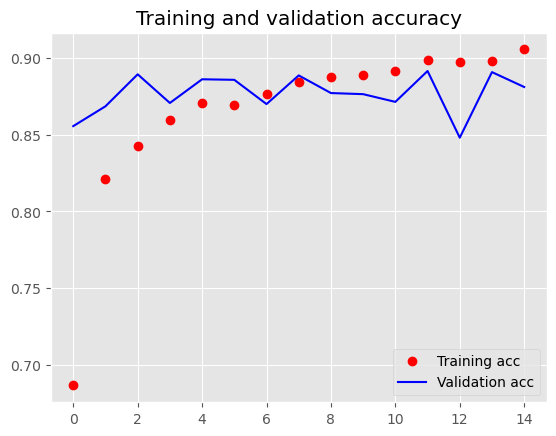

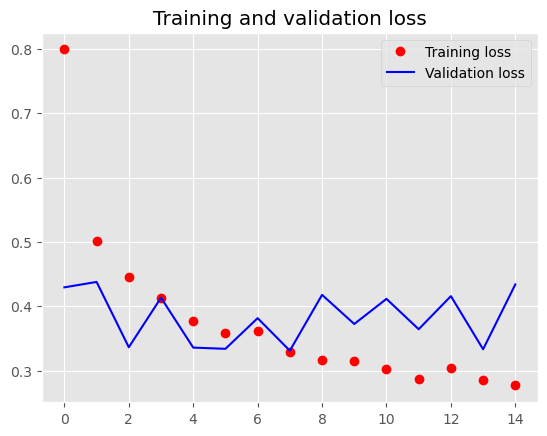

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
y_pred = model.predict(test_generator)
y_pred = [i.argmax() for i in y_pred]
sorted(Counter(y_pred).items())
print(classification_report(y_test, y_pred))

3000/3000 [==============================] - 19s 6ms/step
              precision    recall  f1-score   support

           0       0.79      0.96      0.86       437
           1       0.98      0.95      0.97       474
           2       0.84      0.85      0.84       553
           3       0.87      0.79      0.83       525
           4       0.91      0.92      0.91       510
           5       0.92      0.85      0.88       501

    accuracy                           0.88      3000
   macro avg       0.89      0.89      0.88      3000
weighted avg       0.89      0.88      0.88      3000



In [50]:
model.evaluate(test_generator)

3000/3000 [==============================] - 24s 8ms/step - loss: 0.3634 - accuracy: 0.8823


[0.3633940815925598, 0.8823333382606506]